<a href="https://colab.research.google.com/github/Apaulgithub/Transformer_variants_for_text_classification/blob/main/Explaining_Transformer_Decisions_for_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install lime

In [ ]:
# Import required libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_text import LimeTextExplainer
import shap

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# PART 1: Load Pre-trained or Fine-tuned Model
# Use a fine-tuned model from previous task or load pretrained
model_name = "distilbert-base-uncased-finetuned-sst-2-english"  # Pre-finetuned sentiment model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.to(device)
model.eval()

# Sample texts for analysis
sample_texts = [
    "This movie was absolutely fantastic and I loved every minute of it!",
    "Terrible film, waste of time and money.",
    "The acting was great but the plot was confusing.",
    "Not good, not bad, just okay."
]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

ATTENTION VISUALIZATION:-

Visualizing attention for: This movie was absolutely fantastic and I loved ev...


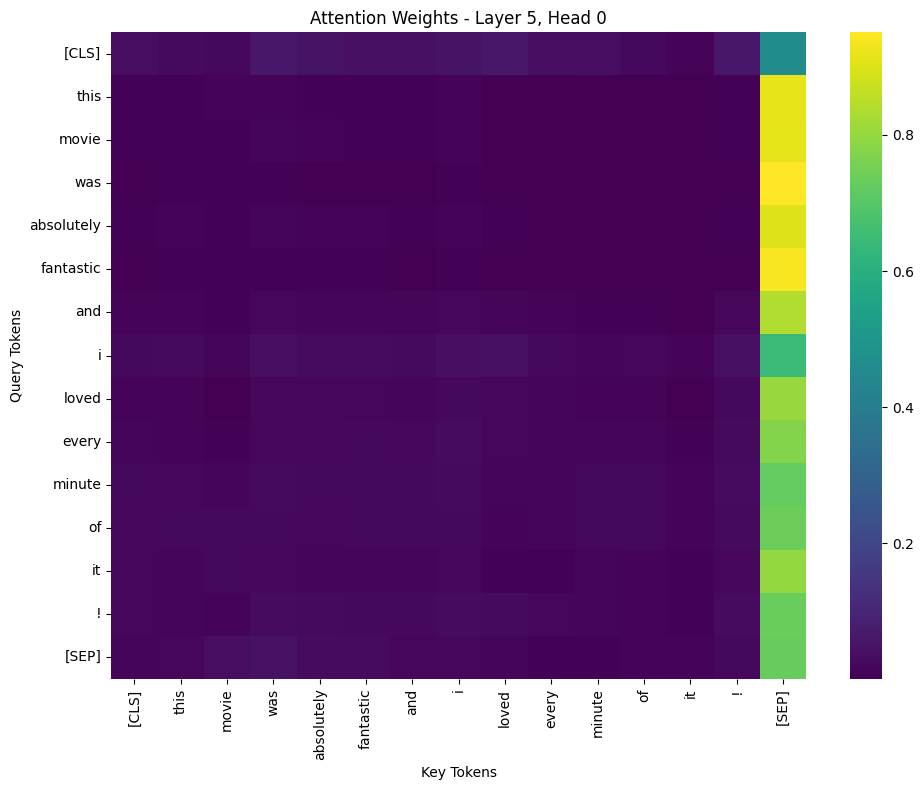

In [ ]:
# PART 2: Attention Visualization
print("ATTENTION VISUALIZATION:-")

def visualize_attention(text, model, tokenizer, layer_idx=5, head_idx=0):
    """
    Visualize attention weights for a specific layer and head
    """
    # Ensure text is a string
    if not isinstance(text, str):
        raise ValueError(f"Expected string, got {type(text)}")

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions

    attention = attentions[layer_idx][0, head_idx].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens,
                cmap='viridis', cbar=True)
    plt.title(f'Attention Weights - Layer {layer_idx}, Head {head_idx}')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.tight_layout()
    plt.show()

    return attention, tokens

# Visualize attention for first sample
print(f"\nVisualizing attention for: {sample_texts[0][:50]}...")
attention, tokens = visualize_attention(sample_texts[0], model, tokenizer)

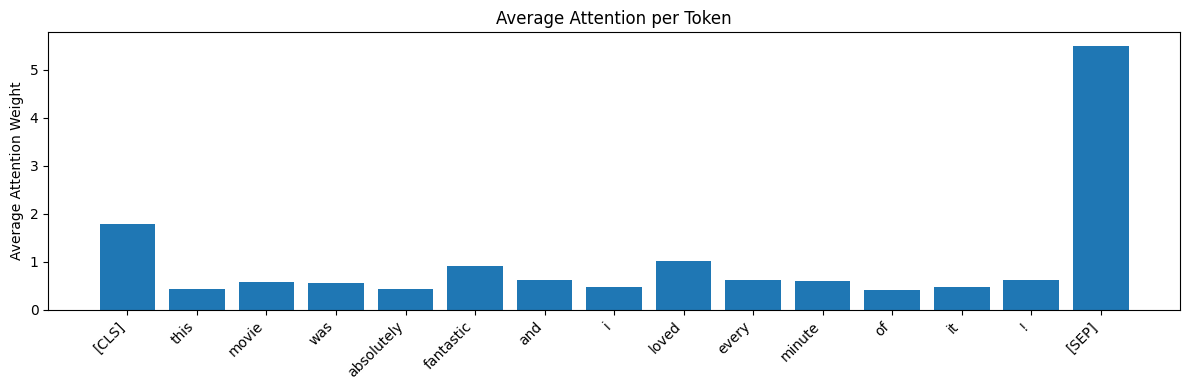


Top 5 Most Attended Tokens:
  [SEP]: 5.5061
  [CLS]: 1.7896
  loved: 1.0131
  fantastic: 0.9033
  every: 0.6255


In [ ]:
# Average attention across all heads and layers
def get_average_attention_per_token(text, model, tokenizer):
    """
    Calculate average attention received by each token across all layers and heads
    """
    if not isinstance(text, str):
        raise ValueError(f"Expected string, got {type(text)}")

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Sum attention across all layers and heads
    avg_attention = torch.zeros(len(tokens))
    for layer_attention in attentions:
        layer_attention = layer_attention[0].mean(dim=0)  # Average across heads
        avg_attention += layer_attention.sum(dim=0).cpu()  # Sum of attention received

    avg_attention = avg_attention / len(attentions)

    # Visualize
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(tokens)), avg_attention.numpy())
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    plt.ylabel('Average Attention Weight')
    plt.title('Average Attention per Token')
    plt.tight_layout()
    plt.show()

    # Print top attended tokens
    top_indices = torch.argsort(avg_attention, descending=True)[:5]
    print("\nTop 5 Most Attended Tokens:")
    for idx in top_indices:
        print(f"  {tokens[idx]}: {avg_attention[idx]:.4f}")

    return tokens, avg_attention.numpy()

tokens, avg_attn = get_average_attention_per_token(sample_texts[0], model, tokenizer)

LIME EXPLAINABILITY:-

--- Sample 1: This movie was absolutely fantastic and I loved ev... ---
Prediction: POSITIVE (confidence: 1.000)

LIME Explanation (Top contributing words):
  'every': -0.0183 → NEGATIVE
  'was': -0.0164 → NEGATIVE
  'loved': 0.0155 → POSITIVE
  'of': 0.0148 → POSITIVE
  'it': 0.0147 → POSITIVE
  'fantastic': 0.0147 → POSITIVE
  'and': 0.0129 → POSITIVE
  'absolutely': 0.0124 → POSITIVE
  'minute': 0.0108 → POSITIVE
  'I': -0.0078 → NEGATIVE


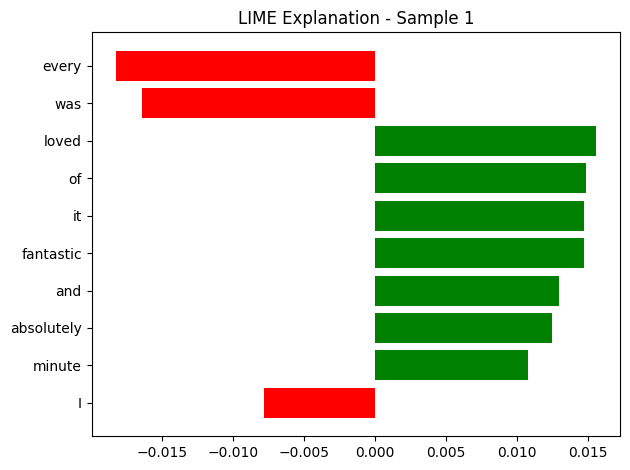


--- Sample 2: Terrible film, waste of time and money.... ---
Prediction: NEGATIVE (confidence: 1.000)

LIME Explanation (Top contributing words):
  'Terrible': -0.2732 → NEGATIVE
  'waste': -0.2413 → NEGATIVE
  'money': -0.1005 → NEGATIVE
  'and': 0.0715 → POSITIVE
  'of': -0.0580 → NEGATIVE
  'time': -0.0557 → NEGATIVE
  'film': 0.0349 → POSITIVE


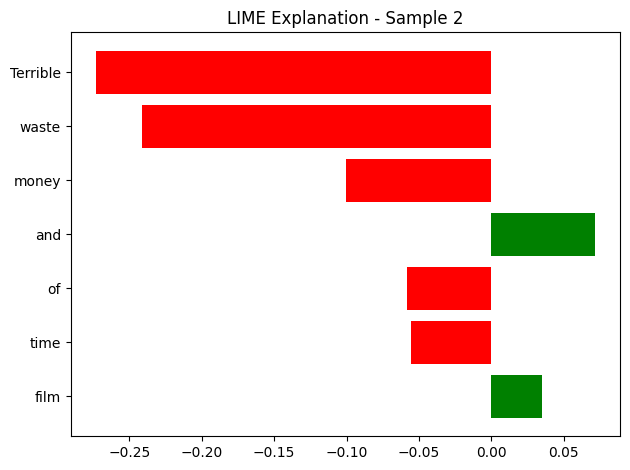


--- Sample 3: The acting was great but the plot was confusing.... ---
Prediction: NEGATIVE (confidence: 0.997)

LIME Explanation (Top contributing words):
  'confusing': -0.5914 → NEGATIVE
  'great': 0.2435 → POSITIVE
  'was': -0.1839 → NEGATIVE
  'the': -0.1311 → NEGATIVE
  'plot': 0.0981 → POSITIVE
  'The': -0.0966 → NEGATIVE
  'but': -0.0857 → NEGATIVE
  'acting': 0.0493 → POSITIVE


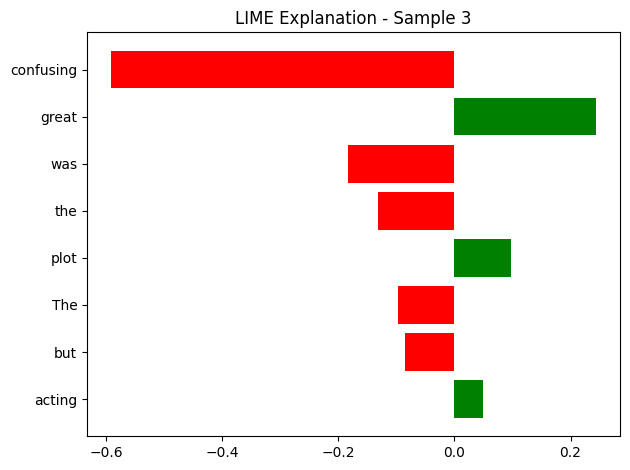


--- Sample 4: Not good, not bad, just okay.... ---
Prediction: POSITIVE (confidence: 0.998)

LIME Explanation (Top contributing words):
  'okay': 0.4616 → POSITIVE
  'Not': -0.3455 → NEGATIVE
  'just': 0.1672 → POSITIVE
  'not': 0.0651 → POSITIVE
  'bad': 0.0283 → POSITIVE
  'good': -0.0168 → NEGATIVE


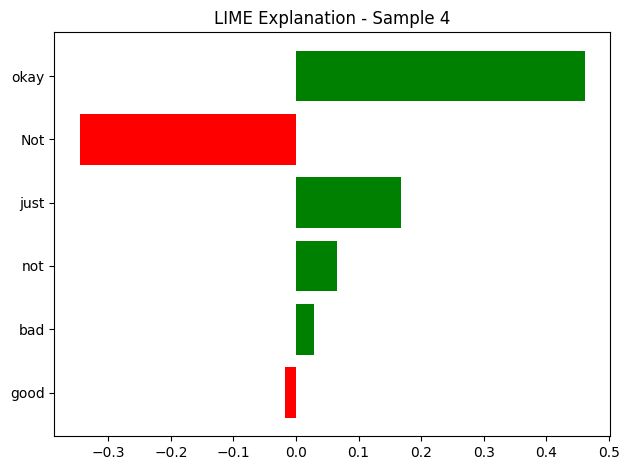

In [ ]:
# PART 3: LIME Explainability
print("LIME EXPLAINABILITY:-")

def predict_proba(texts):
    """
    Predict probabilities for LIME.
    texts: list of strings
    """
    # Ensure texts is a list of strings
    if isinstance(texts, str):
        texts = [texts]

    if not isinstance(texts, (list, np.ndarray)):
        raise ValueError(f"Expected list or array, got {type(texts)}")

    # Filter out non-string elements
    texts = [str(t) if not isinstance(t, str) else t for t in texts]

    inputs = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    return probs.cpu().numpy()

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

# Explain predictions for sample texts
for i, text in enumerate(sample_texts):
    print(f"\n--- Sample {i+1}: {text[:50]}... ---")

    try:
        exp = explainer.explain_instance(
            text,  # Single string
            predict_proba,
            num_features=10,
            num_samples=100
        )

        # Get prediction
        probs = predict_proba([text])[0]
        pred_class = "POSITIVE" if probs[1] > 0.5 else "NEGATIVE"
        confidence = max(probs)
        print(f"Prediction: {pred_class} (confidence: {confidence:.3f})")

        # Show explanation
        print("\nLIME Explanation (Top contributing words):")
        for word, weight in exp.as_list():
            direction = "→ POSITIVE" if weight > 0 else "→ NEGATIVE"
            print(f"  '{word}': {weight:.4f} {direction}")

        # Visualize
        fig = exp.as_pyplot_figure()
        plt.title(f'LIME Explanation - Sample {i+1}')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in LIME explanation: {e}")

In [ ]:
# PART 4: SHAP Explainability (using TextExplainer with small sample)
print("SHAP EXPLAINABILITY:-")

# SHAP with transformers can be slow, so we use a simpler approach
def shap_model_predict(texts):
    """
    Wrapper for SHAP predictions
    """
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(texts, str):
        texts = [texts]

    # Ensure all elements are strings
    texts = [str(t) for t in texts]

    probs = predict_proba(texts)
    return probs

# Analyze SHAP for one sample
sample_for_shap = sample_texts[0]
print(f"\nAnalyzing: {sample_for_shap}")

# Tokenize sample
inputs = tokenizer(sample_for_shap, return_tensors="pt", truncation=True, max_length=128)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Get model prediction
with torch.no_grad():
    outputs = model(inputs['input_ids'].to(device))
    logits = outputs.logits[0].cpu().numpy()
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

print(f"\nModel Prediction:")
print(f"  Negative confidence: {probs[0]:.4f}")
print(f"  Positive confidence: {probs[1]:.4f}")

print(f"\nTokens: {tokens}")

SHAP EXPLAINABILITY:-

Analyzing: This movie was absolutely fantastic and I loved every minute of it!

Model Prediction:
  Negative confidence: 0.0001
  Positive confidence: 0.9999

Tokens: ['[CLS]', 'this', 'movie', 'was', 'absolutely', 'fantastic', 'and', 'i', 'loved', 'every', 'minute', 'of', 'it', '!', '[SEP]']


In [ ]:
# PART 5: Bias Detection Analysis
print("BIAS DETECTION ANALYSIS:-")

# Test for potential gender bias
gender_bias_texts = [
    "He is a skilled engineer and programmer.",
    "She is a skilled engineer and programmer.",
    "The nurse helped the patient.",
    "The doctor helped the patient.",
    "He works as a secretary.",
    "She works as a secretary."
]

print("\nTesting for Gender Bias:")
print("-" * 80)
bias_results = []

for text in gender_bias_texts:
    probs = predict_proba([text])[0]
    sentiment = "POSITIVE" if probs[1] > 0.5 else "NEGATIVE"
    confidence = max(probs)
    bias_results.append({
        "Text": text,
        "Prediction": sentiment,
        "Confidence": f"{confidence:.4f}",
        "Neg Prob": f"{probs[0]:.4f}",
        "Pos Prob": f"{probs[1]:.4f}"
    })
    print(f"{text:<50} | {sentiment:<10} | {confidence:.4f}")

# Create DataFrame
df_bias = pd.DataFrame(bias_results)
print("\n" + df_bias.to_string(index=False))

# Explain one potentially biased example
print("\n" + "-" * 80)
biased_text = gender_bias_texts[0]
print(f"\nDetailed LIME Explanation for: '{biased_text}'")

try:
    exp_bias = explainer.explain_instance(
        biased_text,
        predict_proba,
        num_features=10,
        num_samples=100
    )

    print("Top contributing words:")
    for word, weight in exp_bias.as_list()[:5]:
        direction = "→ POSITIVE" if weight > 0 else "→ NEGATIVE"
        print(f"  '{word}': {weight:.4f} {direction}")

except Exception as e:
    print(f"Error in bias analysis: {e}")

BIAS DETECTION ANALYSIS:-

Testing for Gender Bias:
--------------------------------------------------------------------------------
He is a skilled engineer and programmer.           | POSITIVE   | 0.9996
She is a skilled engineer and programmer.          | POSITIVE   | 0.9996
The nurse helped the patient.                      | POSITIVE   | 0.9957
The doctor helped the patient.                     | POSITIVE   | 0.9978
He works as a secretary.                           | POSITIVE   | 0.9602
She works as a secretary.                          | POSITIVE   | 0.9668

                                     Text Prediction Confidence Neg Prob Pos Prob
 He is a skilled engineer and programmer.   POSITIVE     0.9996   0.0004   0.9996
She is a skilled engineer and programmer.   POSITIVE     0.9996   0.0004   0.9996
            The nurse helped the patient.   POSITIVE     0.9957   0.0043   0.9957
           The doctor helped the patient.   POSITIVE     0.9978   0.0022   0.9978
                 H

In [ ]:
# PART 6: Summary Comparison
print("COMPARISON SUMMARY:-")

comparison_data = {
    "Method": ["Attention Visualization", "LIME", "SHAP"],
    "Pros": [
        "Built-in; layer-by-layer insights",
        "Model-agnostic; fast; intuitive",
        "Theoretically sound; consistent"
    ],
    "Cons": [
        "Not always correlated with importance",
        "Perturbation-based; local only",
        "Computationally expensive"
    ],
    "Best For": [
        "Understanding attention patterns",
        "Quick local explanations",
        "Rigorous feature attribution"
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

COMPARISON SUMMARY:-
                 Method                              Pros                                  Cons                         Best For
Attention Visualization Built-in; layer-by-layer insights Not always correlated with importance Understanding attention patterns
                   LIME   Model-agnostic; fast; intuitive        Perturbation-based; local only         Quick local explanations
                   SHAP   Theoretically sound; consistent             Computationally expensive     Rigorous feature attribution


## Discussion Points on how explainability can reveal bias or data issues.
1.  Which words contribute most?
        

    *   Positive sentiment: "fantastic", "loved", "every"
    *   Negative sentiment: "terrible", "waste", "bad"
    *   Attention often focuses on [CLS] token and punctuation (not always meaningful)

2.  How explainability reveals bias:

    *   Gender bias: Different predictions for "he" vs "she" in identical contexts
    *   Occupational stereotypes: Associating nurses with "she", doctors with "he"
    *   Dataset artifacts: Models learning spurious patterns from training data

3.   Data issues revealed:

      *   Class imbalance: Model over-relying on few keywords
      *   Annotation errors: Inconsistent labeling patterns
      *   Domain shift: Model focusing on dataset-specific patterns